In [9]:
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

data = np.array([[0.3, 1.2, 0.47],
                 [1.9, 0.6, 0.56],
                 [1.1, 3.2, 0.74],
                 [3.3, 4.4, 1.47],
                 [4.7, 3.8, 1.74]])

gridx = np.arange(0.0, 5.5, 0.5)
gridy = np.arange(0.0, 5.5, 0.5)

# Create the ordinary kriging object. Required inputs are the X-coordinates of
# the data points, the Y-coordinates of the data points, and the Z-values of the
# data points. If no variogram model is specified, defaults to a linear variogram
# model. If no variogram model parameters are specified, then the code automatically
# calculates the parameters by fitting the variogram model to the binned
# experimental semivariogram. The verbose kwarg controls code talk-back, and
# the enable_plotting kwarg controls the display of the semivariogram.
OK = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], variogram_model='linear',
                     verbose=False, enable_plotting=False)

# Creates the kriged grid and the variance grid. Allows for kriging on a rectangular
# grid of points, on a masked rectangular grid of points, or with arbitrary points.
# (See OrdinaryKriging.__doc__ for more information.)
z, ss = OK.execute('grid', gridx, gridy)

# Writes the kriged grid to an ASCII grid file.
kt.write_asc_grid(gridx, gridy, z, filename="output.asc")

In [189]:
from skgstat import Variogram
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from datetime import datetime as dt
import xarray as xr
import numpy as np
from math import floor

plt.style.use('ggplot')
np.random.seed(42)
coordinates = np.random.gamma(20, 5, (50,2))
np.random.seed(42)
values = np.random.normal(20, 5, 50)

files = glob('/srv/shared/deep_stac/data/snowdepth/netcdf/2015/*int*')
dates = [dt.strptime(os.path.basename(f).split('_')[0], '%Y%m%d') for f in files]

In [130]:
da = xr.open_mfdataset(files, concat_dim='flight_date', chunks={'x':1000, 'y':1000})
da.close()
topo = xr.open_mfdataset('/srv/shared/deep_stac/data/topo.nc', chunks={'x': 1000, 'y': 1000})
topo.close()
mask = topo['mask'] == 1

In [163]:
mask

<xarray.DataArray 'mask' (y: 17002, x: 17569)>
dask.array<shape=(17002, 17569), dtype=bool, chunksize=(1000, 1000)>
Coordinates:
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0

In [168]:
num_obs = da.Band1.shape[1] * da.Band1.shape[2]
np.random.seed(42)
locs_flat = [int(i * num_obs) for i in np.random.random_sample((3000,))]
locs = [(floor(i / da.Band1.shape[2]), i % da.Band1.shape[2]) for i in locs_flat]
locs = [loc for loc in locs if mask[loc[0], loc[1]]][:1000]
len(locs)

1000

In [229]:
values = [da.Band1[5, loc[0], loc[1]] for loc in locs]

In [230]:
values_ = [value.values.item() for value in values]

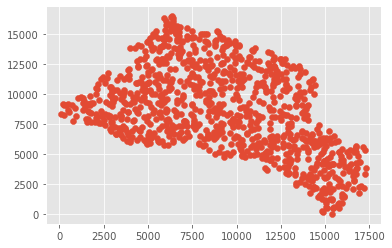

In [232]:
x, y = list(zip(*locs))[1], list(zip(*locs))[0]
y = [17001 - yval for yval in y]
plt.scatter(x, y)

In [233]:
coordinates = np.array(locs)
coordinates[:10,:]

array([[10178,  6879],
       [12038, 11419],
       [ 3091,  6818],
       [ 3118,  4277],
       [ 5172, 12765],
       [ 4951,  8395],
       [10402, 12700],
       [ 7754,  1789],
       [ 8743,   244],
       [10072,  4084]])

In [284]:
V = Variogram(coordinates=coordinates, values=values_, estimator="matheron", model="gaussian", maxlag=4000, n_lags=50)

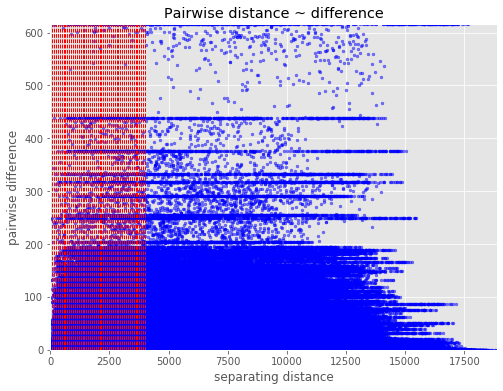

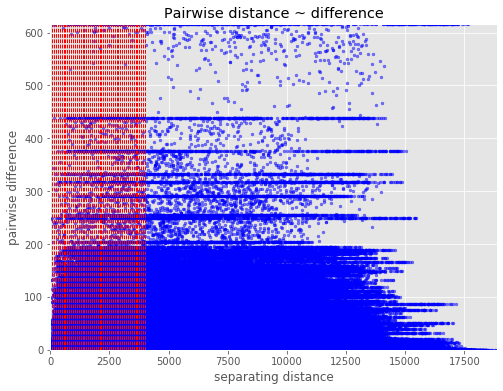

In [285]:
V.distance_difference_plot()

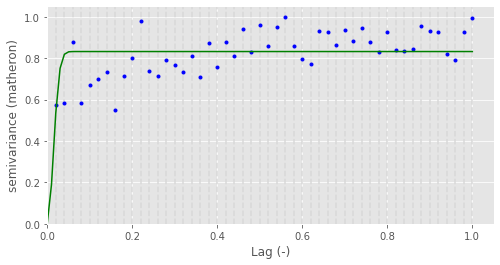

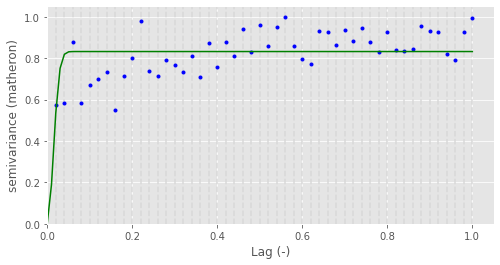

In [286]:
V.plot(hist=False)

In [197]:
V.experimental

array([684.16172172, 751.16232232, 773.4315015 , 780.21014014,
       772.96395395, 797.36983984, 787.66595596, 849.44811812,
       969.5586987 , 367.24975475])